<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs" data-toc-modified-id="Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs-1">Analysis of full-length PacBio sequencing of influenza mRNAs</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span><ul class="toc-item"><li><span><a href="#Import-Python-modules" data-toc-modified-id="Import-Python-modules-1.1.1">Import Python modules</a></span></li><li><span><a href="#Define-/-create-directories" data-toc-modified-id="Define-/-create-directories-1.1.2">Define / create directories</a></span></li><li><span><a href="#How-many-CPUs-to-use" data-toc-modified-id="How-many-CPUs-to-use-1.1.3">How many CPUs to use</a></span></li></ul></li><li><span><a href="#Get-subreads-files-for-each-sequencing-run" data-toc-modified-id="Get-subreads-files-for-each-sequencing-run-1.2">Get subreads files for each sequencing run</a></span></li><li><span><a href="#Build-CCSs" data-toc-modified-id="Build-CCSs-1.3">Build CCSs</a></span></li><li><span><a href="#Identify-barcoded-CCSs" data-toc-modified-id="Identify-barcoded-CCSs-1.4">Identify barcoded CCSs</a></span><ul class="toc-item"><li><span><a href="#Define-features-of-barcoded-CCSs" data-toc-modified-id="Define-features-of-barcoded-CCSs-1.4.1">Define features of barcoded CCSs</a></span></li><li><span><a href="#Defined-expected-attributes-of-barcoded-CCSs" data-toc-modified-id="Defined-expected-attributes-of-barcoded-CCSs-1.4.2">Defined expected attributes of barcoded CCSs</a></span></li><li><span><a href="#Find-barcoded-CCSs,-plot-stats" data-toc-modified-id="Find-barcoded-CCSs,-plot-stats-1.4.3">Find barcoded CCSs, plot stats</a></span></li><li><span><a href="#Examine-unmatched-CCSs" data-toc-modified-id="Examine-unmatched-CCSs-1.4.4">Examine unmatched CCSs</a></span></li></ul></li></ul></li></ul></div>

# Analysis of full-length PacBio sequencing of influenza mRNAs
The material from the 10X libraries for the *IFN_enriched* sample was enriched for viral mRNAs by semi-specific PCR, and then sequenced by PacBio.
Here we analyze those data.

## Set up for analysis
First, we do some things to set up the parameters of the analysis.

### Import Python modules
We import the Python modules used.

Note we use some functions from [dms_tools2](https://jbloomlab.github.io/dms_tools2/).

In [1]:
import os
import glob
import subprocess
import shutil
import multiprocessing
import warnings
import collections
warnings.simplefilter('ignore')

from IPython.display import display, HTML

import dms_tools2.pacbio
from dms_tools2.ipython_utils import showPDF
from dms_tools2.utils import reverseComplement

### Define / create directories
We define the names of key directories for input and output, and create these directories if needed:

In [2]:
# top results directory
resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)

# directory for PacBio results
pacbioresultsdir = os.path.join(resultsdir, 'pacbio')
if not os.path.isdir(pacbioresultsdir):
    os.mkdir(pacbioresultsdir)

### How many CPUs to use
Specify max number to use:

In [3]:
max_cpus = 14 # max number of CPUs to use
ncpus = max(multiprocessing.cpu_count(), max_cpus)

## Get subreads files for each sequencing run
We have multiple sequencing runs:
  - A run from June-8-2017 done at the UW PacBio core. This run used a PacBio RSII machine.
  - A run from December-7-2017 done at the Fred Hutch Genomics core. This run used a PacBio Sequel machine.
  
Note that the material sequenced for these two runs was **not** identical. 
The balance of genes that were mixed differed, as well as the size selection and the way that the libraries were loaded.
Therefore, we do not expect the same balance of different reads in the two runs.

In addition, the data were processed differently.
For the Hutch Genomics Core runs, the data are already processed into a `*.subreads.bam` file, while for UW PacBio core runs it is still in the `*.bas.h5` file.

In [4]:
seqruns = ['2017-06-08', '2017-12-07']

seqdirs = {
        '2017-06-08':'/fh/fast/bloom_j/SR/ngs/pacbio_UW/170608 Pacbio single cell/Emulsion Reaction/ABR_C_MACS.AR_0kb',
        '2017-12-07':'/fh/fast/bloom_j/SR/ngs/pacbio/171207_bloom_j/r54228_20171201_171054/1_A01',
        }

bam_already = {'2017-06-08':False, '2017-12-07':True}

Now we get the `*.subreads.bam` file for each run.
If they already exist (e.g., if data were returned by the Fred Hutch Genomics Core), we just need to get the name of the file.
But if they don't exist (e.g., if data were returned from UW PacBio Core), we need to run the PacBio [bax2bam](https://github.com/PacificBiosciences/bax2bam) software to create the `*subreads.bam` files from the `*.bas.h5` files.

In [5]:
# put or copy subreads into this directory
subreadsdir = os.path.join(pacbioresultsdir, 'subreads')
if not os.path.isdir(subreadsdir):
    os.mkdir(subreadsdir)

# store name of subreads files for each sequencing run
subreads = dict([(seqrun, os.path.join(subreadsdir, seqrun + '.subreads.bam'))
                 for seqrun in seqruns])

# get subreads files
for (seqrun, subreadsfile) in subreads.items():
    print("\nGetting subreads for {0} sequencing run".format(seqrun))
    
    if os.path.isfile(subreadsfile):
        print("Subreads file already exists: {0}".format(subreadsfile))
    
    elif bam_already[seqrun]:
        print("Looking for existing subreads file...")
        filepattern = os.path.join(seqdirs[seqrun], '*.subreads.bam')
        existingfiles = glob.glob(filepattern)
        assert existingfiles, "No file matching expected pattern of {0}".format(filepattern)
        assert len(existingfiles) == 1, "Expected one file, but found multiple:\n{0}".format(
                '\n'.join(existingfiles))
        print("Copying subreads file {0} to {1}...".format(existingfiles[0], subreadsfile))
        shutil.copy(existingfiles[0], subreadsfile)
        shutil.copy(existingfiles[0] + '.pbi', subreadsfile + '.pbi')
        print("Completed copying file.")
    
    else:
        print("Building subreads using `bax2bam` version {0}".format(
                subprocess.check_output(['bax2bam', '--version']).decode('utf-8').strip()))
        baxfiles = []
        for (dpath, dirnames, fnames) in os.walk(seqdirs[seqrun]):
            baxfiles += [os.path.join(dpath, fname) for fname in fnames if fname.endswith('.bax.h5')] 
        assert len(baxfiles) > 0, "found no `*.bax.h5` files"
        print("Will build subreads from the following `*.bax.h5` files:\n\t{0}".format(
                '\n\t'.join(baxfiles)))
        print("Now running `bax2bam`...")
        ! bax2bam \
                {' '.join(['"' + x + '"' for x in baxfiles])} \
                -o {subreadsfile.replace('.subreads.bam', '')} \
                --subread
        print("Completed running `bax2bam` to create {0}".format(subreadsfile))
        assert os.path.isfile(subreadsfile)


Getting subreads for 2017-06-08 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-06-08.subreads.bam

Getting subreads for 2017-12-07 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-12-07.subreads.bam


## Build CCSs
We build circular consensus sequences (CCS) using PacBio's algorithm as implemented in the [ccs program](https://github.com/PacificBiosciences/unanimity/blob/develop/doc/PBCCS.md).

We only want reasonably high-quality CCSs.
The [ccs program](https://github.com/PacificBiosciences/unanimity/blob/master/doc/PBCCS.md) provides two ways to control the "accuracy" of reads.
The first is the `--minPasses` option, which corresponds to how many subreads we require to call a circular consensus sequence.
The second is the `--minPredictedAccuracy` option, which provides an explicit estimate of the accuracy.
We will further post-process the CCSs, so we set reasonably high but not extremely stringent values: 3 passes, and at least 99.9% accuracy:


Running `ccs` for sequencing run 2017-06-08
The `ccs` output already exists, so using that existing output.

Running `ccs` for sequencing run 2017-12-07
The `ccs` output already exists, so using that existing output.

Here are statistics on the `ccs` results:


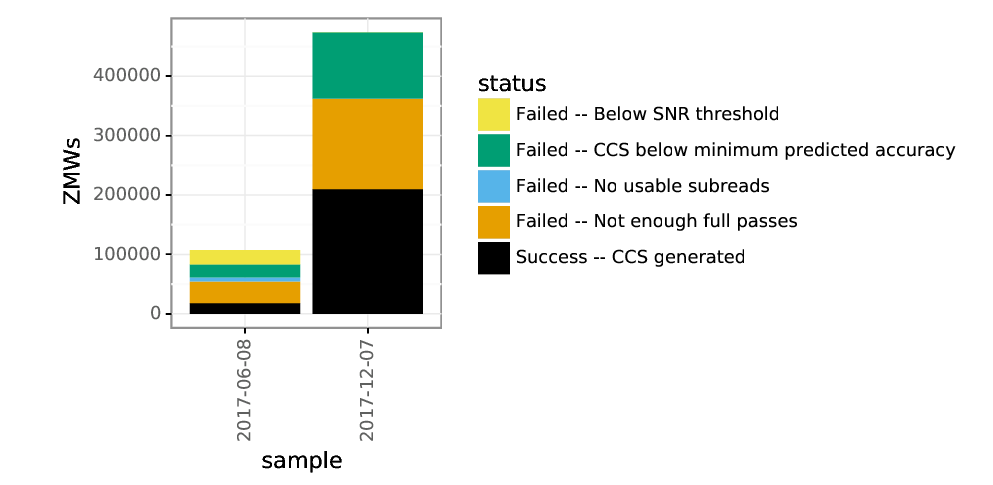

sample,status,number,fraction
2017-12-07,Success -- CCS generated,209930,0.4428
2017-12-07,Failed -- Not enough full passes,152429,0.3215
2017-12-07,Failed -- CCS below minimum predicted accuracy,110974,0.2341
2017-06-08,Failed -- Not enough full passes,36289,0.3371
2017-06-08,Failed -- Below SNR threshold,24052,0.2235
2017-06-08,Failed -- CCS below minimum predicted accuracy,22063,0.2050
2017-06-08,Success -- CCS generated,18063,0.1678
2017-06-08,Failed -- No usable subreads,6810,0.0633


In [6]:
ccsdir = os.path.join(pacbioresultsdir, 'ccs')
if not os.path.isdir(ccsdir):
    os.mkdir(ccsdir)

ccslist = []
for (seqrun, subreadsfile) in subreads.items():
    print("\nRunning `ccs` for sequencing run {0}".format(seqrun))
        
    reportfile = os.path.join(ccsdir, seqrun + '_report.csv')
    bamfile = os.path.join(ccsdir, seqrun + '_ccs.bam')
    logfile = os.path.join(ccsdir, seqrun + '_log.txt')
        
    if all(map(os.path.isfile, [reportfile, bamfile])):
        print("The `ccs` output already exists, so using that existing output.")
    else:  
        print("Running {0}...".format(
                subprocess.check_output(['ccs', '--version']).decode(
                'utf-8').strip()))
        ! ccs \
            --minLength 100 \
            --maxLength 5000 \
            --minPasses 3 \
            --minPredictedAccuracy 0.999 \
            --logFile {logfile} \
            --reportFile {reportfile} \
            --polish \
            --numThreads {ncpus} \
            {subreadsfile} \
            {bamfile}
        print("Completed `ccs` run.")
        
    ccslist.append(dms_tools2.pacbio.CCS(seqrun, bamfile, reportfile))

print("\nHere are statistics on the `ccs` results:")
zmw_plot = os.path.join(ccsdir, 'ZMW_plot.pdf')
showPDF(zmw_plot)

ccs_report = dms_tools2.pacbio.summarizeCCSreports(
                ccslist, 'zmw', zmw_plot)
display(HTML(ccs_report.query('fraction > 0.005').to_html(index=False)))

## Identify barcoded CCSs
The PacBio sequencing was performed on PCR-amplified product.
This PCR product was amplified off the 10X barcoded material using semi-specific PCR with one end specifically annealing to flu transcripts.

### Define features of barcoded CCSs
This [10X technical note](https://teichlab.github.io/scg_lib_structs/data/CG000108_AssayConfiguration_SC3v2.pdf) outlines the sequences appended by the v2 10X single-cell 3' kit used in these experiments. 
Specifically:
![./data/images/10Xschematic.png](./data/images/10Xschematic.png)

Zooming in on the 3' adaptor sequence, it is:
`CTACACGACGCTCTTCCGATCT-NNNNNNNNNNNNNNNN-NNNNNNNNNN-TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTVN` where the dash-delimited sequences are the read-1 priming site, the 16XN cell barcode, the 10XN UMI, the 30XT oligo-dT primer, followed by `V` (anything but `T`) and `N` (nominally, first nucleotide of upstream of mRNA polyA tail).

For the PCR to enrich the 10X product, Alistair used a 3' primer that anneals to this adaptor, namely:

In [7]:
primer3 = 'CTACACGACGCTCTTCCGATCT'
print("The length of the 3' primer is {0} nt".format(len(primer3)))

The length of the 3' primer is 22 nt


For the 5' primer, Alistair used a mix of primers that covered each of the 8 flu gene segments:

In [8]:
primer5_mix = {'PB2':'GCGAAAGCAGGTCAATTATATTCAATATGGAAAG',
               'PB1':'GCGAAAGCAGGCAAACCATTTG',
               'PA':'GCGAAAGCAGGTACTGATTCAAAATGG',
               'HA':'GCAAAAGCAGGGGAAAATAAAAACAACC',
               'NP':'GCAAAAGCAGGGTAGATAATCACTCAC',
               'NA':'GCGAAAGCAGGAGTTTAAATGAATCCAAAC',
               'M':'GCAAAAGCAGGTAGATATTGAAAGATGAGTC',
               'NS':'GCAAAAGCAGGGTGACAAAGACATAATG',
              }
print("The length of the 5' primer ranges from {0} to {1} nt".format(
        min(map(len, primer5_mix.values())), max(map(len, primer5_mix.values()))))

The length of the 5' primer ranges from 22 to 34 nt


### Defined expected attributes of barcoded CCSs
We now create a `match_str` that can be passed to `dms_tools2.pacbio.CCS.filterSeqs` that covers the expected termini and matches the cell barcodes and UMIs as well.
Note that we write the string so that it matches the reads in the sense of the mRNA, which means we are reverse-complementing the 3' adaptor shown above.
We also don't require matches with the first 5 nucleotides of the expected 5' and 3' termini, since those sometimes seem to be off / missing in the PacBio CCS sequences. 

The components of the match are:
  - any 5' primer from Alistair's mix, trimmed a bit at the start
  - the mRNA itself
  - the polyA, allowing it to be somewhat longer / shorter than expected 30 from 10X primer
  - the 10-nucleotide UMI from the 10X primer
  - the 16-nucleotide cell barcode from the 10X primer
  - the 3' primer that Alistair used, which anneals in the read 1 primer binding site on the 10X primer

In [9]:
trim_ends = 5 # trim this many off each end of required matches

# define components of proper CCSs (5' to 3' in mRNA sense)
match_str_parts = collections.OrderedDict([
        ('termini5', '|'.join([s[trim_ends : ] for s in primer5_mix.values()])),
        ('mrna', 'N+'),
        ('polyA', 'A{25,35}'),
        ('umi', 'N{10}'),
        ('cell_barcode', 'N{16}'),
        ('termini3', reverseComplement(primer3[trim_ends : ]))
        ])

# build match_str from all these components
match_str = ''.join(['(?P<{0}>{1})'.format(*tup) for tup in match_str_parts.items()])

print("Here is the match_str we will search for:\n{0}".format(match_str))

Here is the match_str we will search for:
(?P<termini5>AGCAGGTCAATTATATTCAATATGGAAAG|AGCAGGCAAACCATTTG|AGCAGGTACTGATTCAAAATGG|AGCAGGGGAAAATAAAAACAACC|AGCAGGGTAGATAATCACTCAC|AGCAGGAGTTTAAATGAATCCAAAC|AGCAGGTAGATATTGAAAGATGAGTC|AGCAGGGTGACAAAGACATAATG)(?P<mrna>N+)(?P<polyA>A{25,35})(?P<umi>N{10})(?P<cell_barcode>N{16})(?P<termini3>AGATCGGAAGAGCGTCG)


### Find barcoded CCSs, plot stats
Now we use `dms_tools2.pacbio.CCS.filterSeqs` to find barcoded sequences with all the proper compoments, which we will denote as "barcoded".

We then plot statistics on the length, accuracy, and number of passes for all CCSs and those for which we could match termini / barcodes.
We see that we could match the termini / barcodes on only about 15%-20% of all the CCSs.
The length distribution is somewhat spikier for the matched ones, which makes sense if the matches mostly correspond to influenza mRNAs, which have defined lengths.

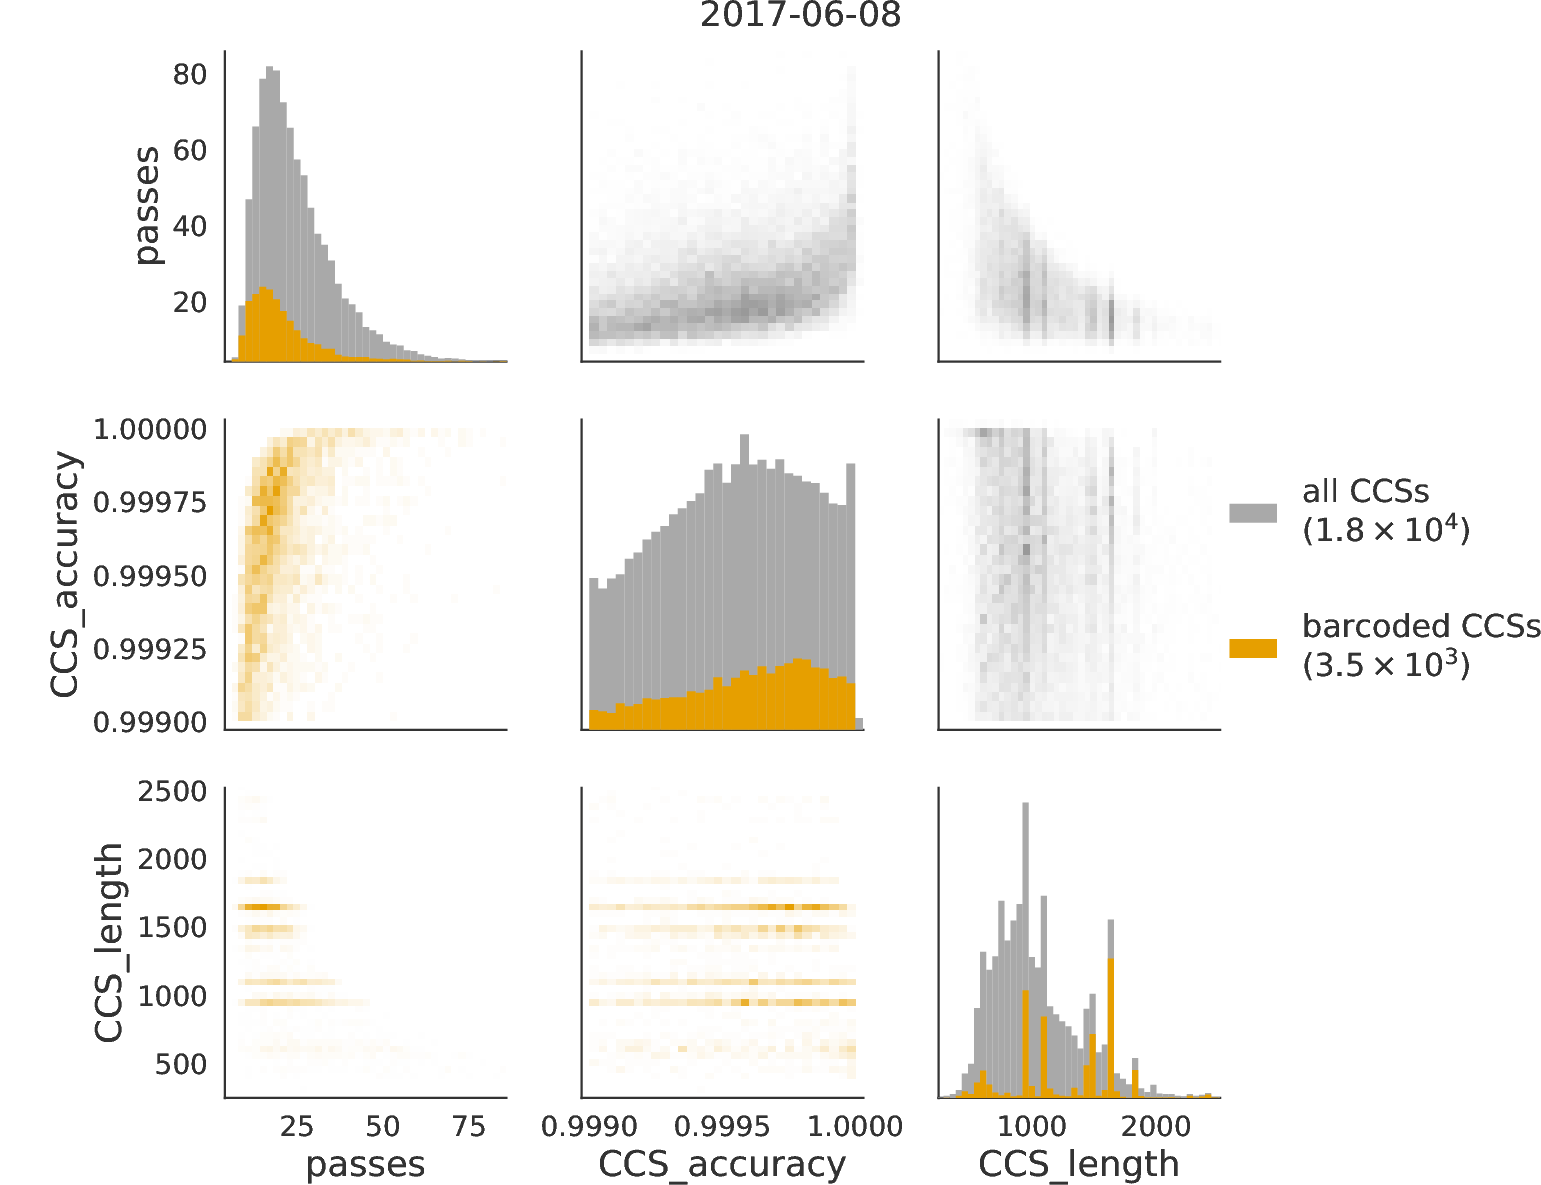

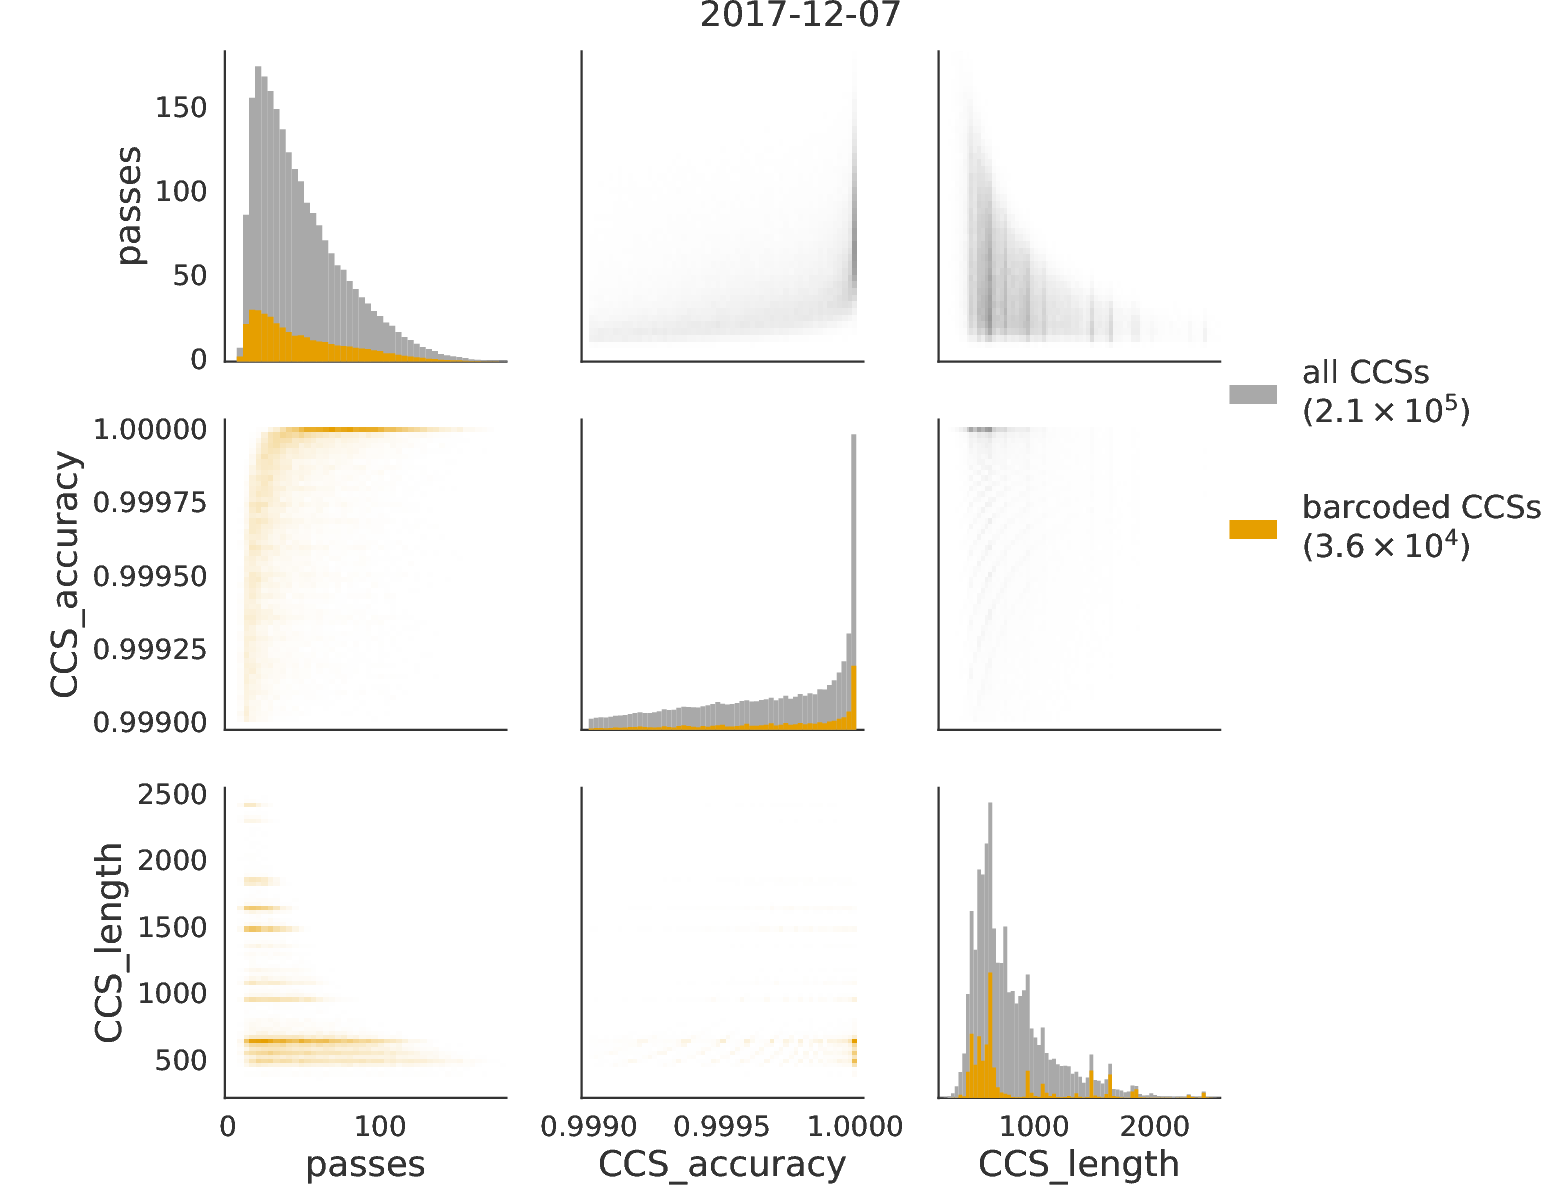

In [10]:
for ccs in ccslist:
    ccs.filterSeqs(match_str, filter_colname='barcoded')
    ccs_plot = os.path.join(ccsdir, ccs.name + '_CCS_plot.pdf')
    ccs.plotResults(ccs_plot, lower_filter='barcoded')
    showPDF(ccs_plot)

### Examine unmatched CCSs
What is happening the the CCSs that we did **not** match?

In [12]:
for pattern in ['termini5', 'termini3', 'polyA']:
    for ccs in ccslist:
        ccs.filterSeqs(match_str_parts[pattern],
                       filter_colname='has_{0}'.format(pattern))

In [15]:
ccs.df.groupby(['barcoded', 'has_termini5', 'has_termini3', 'has_polyA']).CCS.aggregate('count')

barcoded  has_termini5  has_termini3  has_polyA
False     False         False         False           240
                                      True             95
                        True          False         16174
                                      True         147888
          True          False         False           429
                                      True            348
                        True          False          6964
                                      True           1755
True      True          True          True          36037
Name: CCS, dtype: int64